In [1]:
import pandas as pd

In [2]:
all_merged = pd.DataFrame({'category_type': [], 'category': [], 'inflation_without_shelter': [], 'inflation_with_shelter': []})


# Deciles

In [3]:
longNameOfDiscriminatingColumn = "decile"
discriminatingColumn = "DECUC"

In [4]:
df_106 = pd.read_csv("computed_data/106_inflation_March_2022.csv")
df_106_avoided = pd.read_csv("computed_data/106_inflation_avoided.csv")

In [5]:
merged = df_106.merge(right=df_106_avoided, on=discriminatingColumn)

In [6]:
merged["inflation_without_shelter"] = merged['weight_Group_inflation_2022_03'] + merged['inflation_avoided']

In [7]:
merged = merged.rename(columns={discriminatingColumn: 'category_type', 'weight_Group_inflation_2022_03': 'inflation_with_shelter'})
merged['category'] = longNameOfDiscriminatingColumn

In [8]:
merged.sort_values(by='category_type', inplace=True)

In [9]:
all_merged = pd.concat([merged, all_merged])

# Age

In [10]:
translations = {'1': 'Less than 25 years',
                '2': '25-34 years',
                '3': '35-44 years',
                '4': '45-54 years',
                '5': '55-64 years',
                '6': '65-74 years',
                '7': '75 years or older'}
TFnumber = 102
discriminatingColumn = "AGPR"
longNameOfDiscriminatingColumn = "age"

In [11]:

df = pd.read_csv(f"computed_data/{TFnumber}_inflation_March_2022.csv")
df_avoided = pd.read_csv(f"computed_data/{TFnumber}_inflation_avoided.csv")

In [12]:
df_avoided[discriminatingColumn] = df_avoided[discriminatingColumn].astype(str).replace(translations)

In [13]:
merged = df.merge(right=df_avoided, on=discriminatingColumn)

In [14]:
merged["inflation_without_shelter"] = merged['weight_Group_inflation_2022_03'] + merged['inflation_avoided']

In [15]:
merged = merged.rename(columns={discriminatingColumn: 'category_type', 'weight_Group_inflation_2022_03': 'inflation_with_shelter'})
merged['category'] = longNameOfDiscriminatingColumn

In [16]:
all_merged = pd.concat([merged, all_merged])

# Socioeconomic category

In [17]:
TFnumber = '103'
# create a dictionary with the translations
longNameOfDiscriminatingColumn = "socioeconomic category"
# create a dictionary with the translations
translations = {
    "1": "Farmers",
    "2": "Craftsmen, traders and business owners",
    "3": "Executives",
    "4": "Intermediate professions",
    "5": "Employees",
    "6": "Workers",
    "7": "Retirees",
    "8": "Other inactive"
}
discriminatingColumn = "CSPR"

In [18]:

df = pd.read_csv(f"computed_data/{TFnumber}_inflation_March_2022.csv")
df_avoided = pd.read_csv(f"computed_data/{TFnumber}_inflation_avoided.csv")

In [19]:
df_avoided[discriminatingColumn] = df_avoided[discriminatingColumn].astype(str).replace(translations)

In [20]:
merged = df.merge(right=df_avoided, on=discriminatingColumn)

In [21]:
merged["inflation_without_shelter"] = merged['weight_Group_inflation_2022_03'] + merged['inflation_avoided']

In [22]:
merged = merged.rename(columns={discriminatingColumn: 'category_type', 'weight_Group_inflation_2022_03': 'inflation_with_shelter'})
merged['category'] = longNameOfDiscriminatingColumn

In [23]:
all_merged = pd.concat([merged, all_merged])

# Category of residential municipality

In [24]:
longNameOfDiscriminatingColumn = "category of residential municipality"
TFnumber = "104"
discriminatingColumn = "STRATE"
translations = {'0': 'Rural', '1': 'Small-sized towns', '2': 'Medium-sized towns', '3': 'Large cities', '4': 'Paris metropolitan area'}


In [25]:

df = pd.read_csv(f"computed_data/{TFnumber}_inflation_March_2022.csv")
df_avoided = pd.read_csv(f"computed_data/{TFnumber}_inflation_avoided.csv")

In [26]:
df_avoided[discriminatingColumn] = df_avoided[discriminatingColumn].astype(str).replace(translations)

In [27]:
merged = df.merge(right=df_avoided, on=discriminatingColumn)

In [28]:
merged["inflation_without_shelter"] = merged['weight_Group_inflation_2022_03'] + merged['inflation_avoided']

In [29]:
merged = merged.rename(columns={discriminatingColumn: 'category_type', 'weight_Group_inflation_2022_03': 'inflation_with_shelter'})
merged['category'] = longNameOfDiscriminatingColumn

In [30]:
all_merged = pd.concat([merged, all_merged])

# Household type

In [31]:
TFnumber = '105'
# create a dictionary with the translations
longNameOfDiscriminatingColumn = "household type"
# create a dictionary with the translations
translations = {'1': 'Single-person households',
                '2': 'Single-parent families',
                '3': 'Couples without children',
                '4': 'Couples with children',
                '5': 'Other households'}

discriminatingColumn = "TYPMEN"

In [32]:

df = pd.read_csv(f"computed_data/{TFnumber}_inflation_March_2022.csv")
df_avoided = pd.read_csv(f"computed_data/{TFnumber}_inflation_avoided.csv")

In [33]:
df_avoided[discriminatingColumn] = df_avoided[discriminatingColumn].astype(str).replace(translations)

In [34]:
merged = df.merge(right=df_avoided, on=discriminatingColumn)

In [35]:
merged["inflation_without_shelter"] = merged['weight_Group_inflation_2022_03'] + merged['inflation_avoided']

In [36]:
merged = merged.rename(columns={discriminatingColumn: 'category_type', 'weight_Group_inflation_2022_03': 'inflation_with_shelter'})
merged['category'] = longNameOfDiscriminatingColumn

In [37]:
all_merged = pd.concat([merged, all_merged])

# Occupancy status of the main residence

In [38]:
TFnumber = '107'
# create a dictionary with the translations
longNameOfDiscriminatingColumn = "occupancy status of the main residence"
# create a dictionary with the translations
translations = {'P': 'Owner',
                'L': 'Renter'}


discriminatingColumn = "STATUT"

In [39]:

df = pd.read_csv(f"computed_data/{TFnumber}_inflation_March_2022.csv")
df_avoided = pd.read_csv(f"computed_data/{TFnumber}_inflation_avoided.csv")

In [40]:
df_avoided[discriminatingColumn] = df_avoided[discriminatingColumn].astype(str).replace(translations)

In [41]:
merged = df.merge(right=df_avoided, on=discriminatingColumn)

In [42]:
merged["inflation_without_shelter"] = merged['weight_Group_inflation_2022_03'] + merged['inflation_avoided']

In [43]:
merged = merged.rename(columns={discriminatingColumn: 'category_type', 'weight_Group_inflation_2022_03': 'inflation_with_shelter'})
merged['category'] = longNameOfDiscriminatingColumn

In [44]:
all_merged = pd.concat([merged, all_merged])

# Chart

In [45]:
all_merged = all_merged.loc[:, ['category', 'category_type', 'inflation_with_shelter', 'inflation_avoided']]


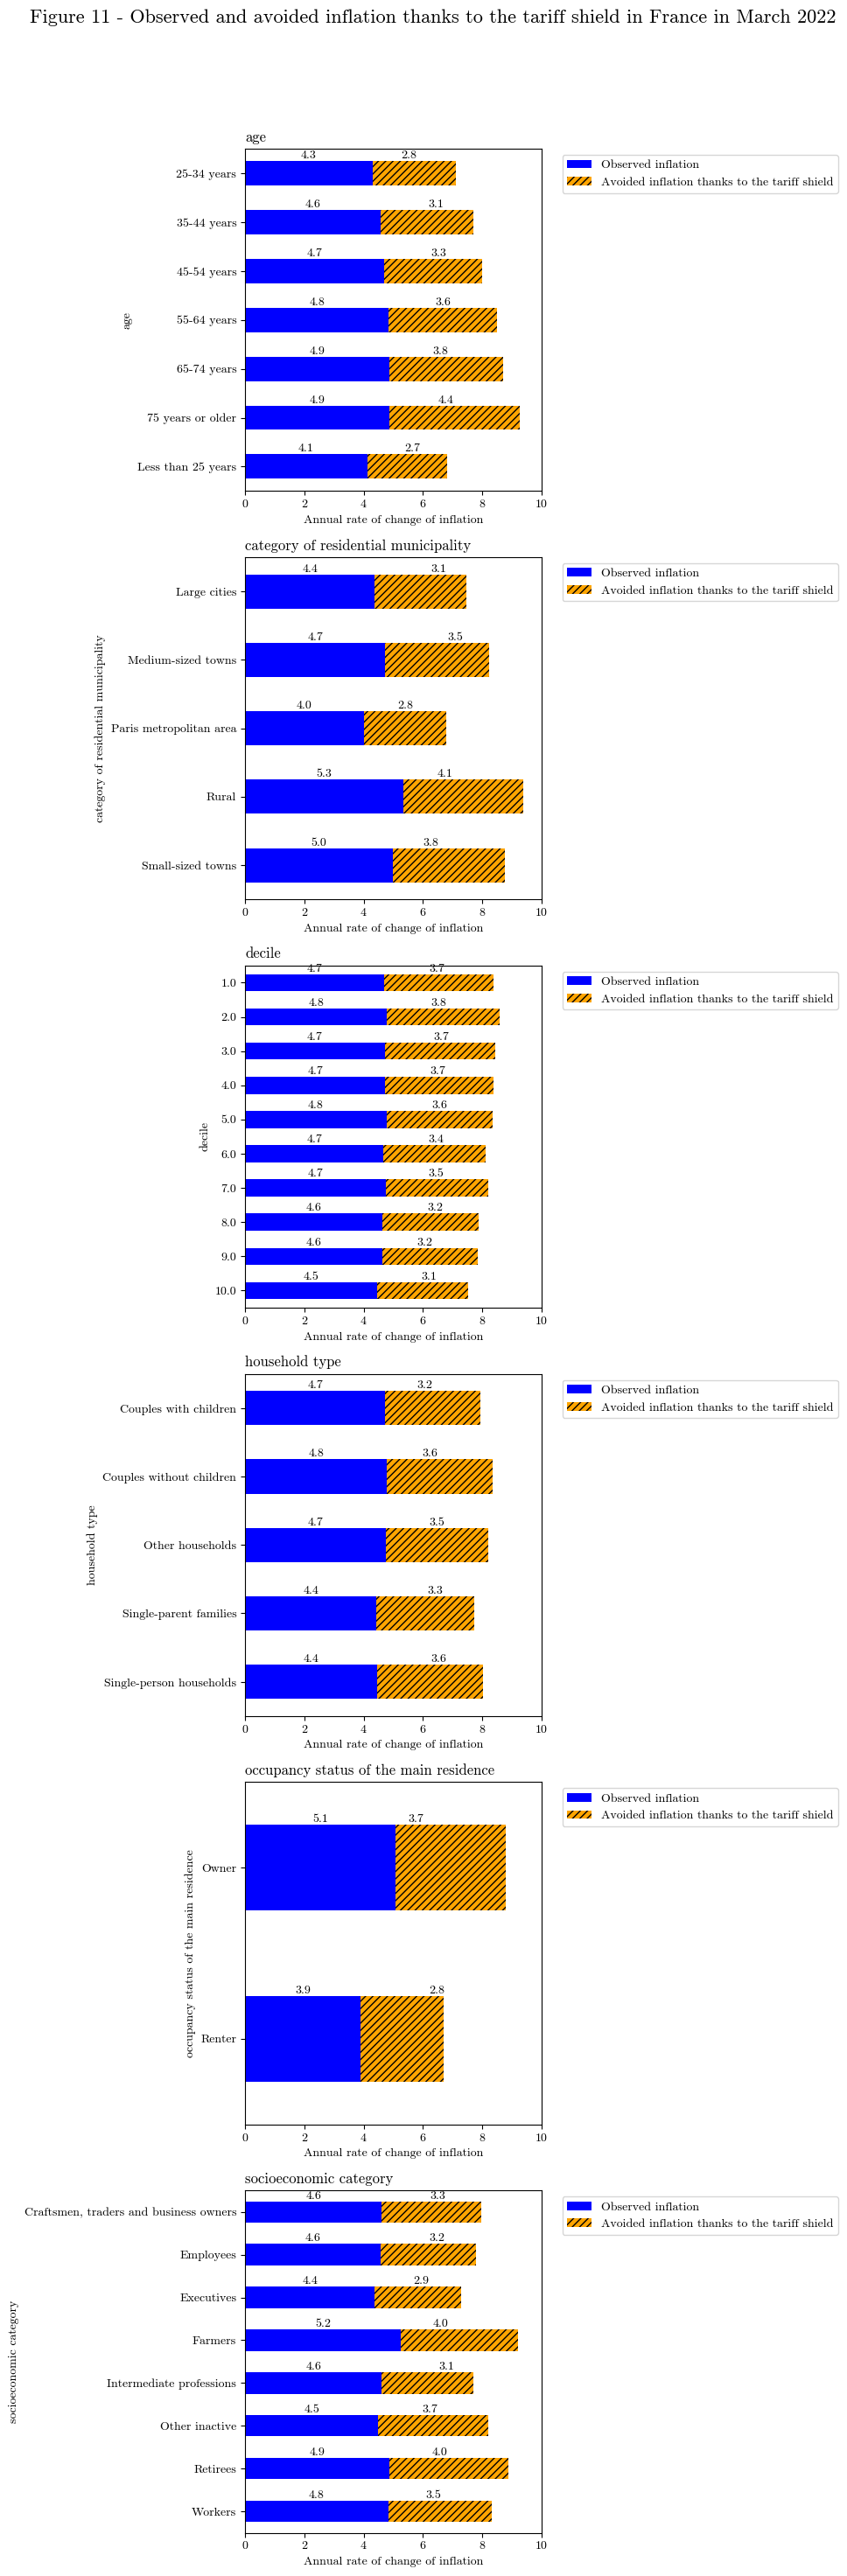

In [46]:

import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'cmr10'


fig, axs = plt.subplots(len(all_merged['category'].unique()), figsize=(10, 30))

for i, (cat, df) in enumerate(all_merged.groupby('category')):
    df = df.iloc[::-1]
    ax = axs[i]

    # Plot the 'inflation_with_shelter' series with blue bars
    df.plot(kind='barh', x='category_type', y='inflation_with_shelter', color='blue', ax=ax)

    # Plot the 'inflation_avoided' series with orange bars and hatching
    df.plot(kind='barh', x='category_type', y='inflation_avoided', color='orange', ax=ax, hatch='////', left=df['inflation_with_shelter'])

    # Add value labels inside the bars
    for j, val in enumerate(df['inflation_with_shelter']):
        ax.annotate(f'{val:.1f}', xy=(val/2, j + 0.25), va='bottom', ha='center', color='black', fontweight='bold')
    for j, val in enumerate(df['inflation_avoided']):
        ax.annotate(f'{val:.1f}', xy=(val/2 + df['inflation_with_shelter'][j], j + 0.25), va='bottom', ha='center', color='black', fontweight='bold')

    ax.set_xlim(0, 10)

    ax.set_ylabel(cat)
    ax.set_xlabel("Annual rate of change of inflation")
    ax.legend(['Observed inflation', 'Avoided inflation thanks to the tariff shield'], title=None, bbox_to_anchor=(1.05, 1), loc='upper left')

    ax.set_yticklabels(df['category_type'], rotation=0)
    ax.set_yticks(range(len(df)))
    ax.set_title(cat, loc='left')



fig.suptitle('Figure 11 - Observed and avoided inflation thanks to the tariff shield in France in March 2022', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95]) 

plt.show()


